In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
df = pd.read_csv('../data/train.csv')
df = df.drop(columns=['Unnamed: 0'])

df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [23]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df["preprocessed_news"] = df["preprocessed_news"].apply(review_cleaning)


In [24]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_train = df.drop(['label'], axis = 1)
Y_train = df['label']

In [25]:
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
maxlen=256
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=8000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()

##### Logistic Regression


In [26]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,Y_train)
lr_classifier_train = round(lr_classifier.score(X_train, Y_train) * 100, 2)

with open('../models/logisticRegression.pkl', 'wb') as arquivo:
    pickle.dump(lr_classifier, arquivo)

##### Multilayer perceptron (MLP)

In [27]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train,Y_train)
mlp_train = round(mlp.score(X_train, Y_train) * 100, 2)

with open('../models/MLPClassifier.pkl', 'wb') as arquivo:
    pickle.dump(mlp, arquivo)


##### Multilayer perceptron (MLP) Com GridSearchCV

In [28]:
parameters = {'solver': ['sgd', 'lbfgs'],
              'hidden_layer_sizes':(20, 10,4), 
              'random_state':[2],
              'activation': ['tanh', 'relu'],
              'max_iter': [2000000],
              "batch_size" : ["auto"],
              "learning_rate_init": [0.004],
              "validation_fraction":[0.3],
              "learning_rate": ['constant']
              }

clf = GridSearchCV(MLPClassifier(), parameters, cv=2)
clf.fit(X_train,Y_train)
mlpG_train = round(clf.score(X_train, Y_train) * 100, 2)


with open('../models/MLPClassifierWithGridSearchCV.pkl', 'wb') as arquivo:
    pickle.dump(clf, arquivo)


#### Decision Tree

In [29]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train,Y_train)
decisionTree_train = round(clf.score(X_train, Y_train) * 100, 2)

with open('../models/decisionTree.pkl', 'wb') as arquivo:
    pickle.dump(decisionTree, arquivo)

#### RNN

In [ ]:
output_dim = 64
epochs = 60
tf.keras.backend.clear_session()

modelSimpleRNN = tf.keras.models.Sequential()
modelSimpleRNN.add(tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen))
modelSimpleRNN.add(tf.keras.layers.GRU(60, activation='tanh', return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.Conv1D(30, 3, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.LSTM(30, return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.SimpleRNN(3, activation='tanh'))
modelSimpleRNN.add(tf.keras.layers.Dropout(0.25))
modelSimpleRNN.add(tf.keras.layers.Dense(24, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))
modelSimpleRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historySimpleRNN = modelSimpleRNN.fit(train_padded_seqeunces, Y_train, epochs=epochs, validation_split=0.3)
rnn_train = round(historySimpleRNN.history['accuracy'][-1] * 100, 2)
modelSimpleRNN.save('../models/modelo_rnn.keras')


#### LSTM (BI)

In [20]:
output_dim = 64
epochs = 200
batch_size = 32
tf.keras.backend.clear_session()

modelLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historyLSTM = modelLSTM.fit(train_padded_seqeunces, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
LSTM_train = round(historyLSTM.history['accuracy'][-1] * 100, 2)
modelLSTM.save('../models/modelLSTM.keras')

## Test

In [55]:
maxlen=256

df_test = pd.read_csv('../data/pre-processed.csv')

stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(remover_stop_words)
df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(review_cleaning)

df_test['label'] = df_test.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_test = df_test['preprocessed_news'].apply(lambda x: x.lower())

test_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
test_tokenizer.fit_on_texts(X_test.values)
test_word_index = test_tokenizer.word_index
test_sequences = test_tokenizer.texts_to_sequences(X_test)
vocab_length = len(test_word_index) + 1
maxlen=256
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=8000)
vectorizer.fit(X_test)
X_test = vectorizer.transform(X_test).toarray()
Y_test = df_test['label']


In [56]:
with open('../models/logisticRegression.pkl', 'rb') as arquivo:
    lr_classifier = pickle.load(arquivo)
with open('../models/MLPClassifier.pkl', 'rb') as arquivo:
    mlp = pickle.load(arquivo)
with open('../models/MLPClassifierWithGridSearchCV.pkl', 'rb') as arquivo:
    mlpG = pickle.load(arquivo)
with open('../models/decisionTree.pkl', 'rb') as arquivo:
    decisionTree = pickle.load(arquivo)
    
rnn = load_model('../models/modelo_rnn.keras')
modelLSTM = load_model('../models/modelLSTM.keras')


##### Logistic Regression


              precision    recall  f1-score   support

           0       0.59      1.00      0.74      3600
           1       1.00      0.30      0.46      3600

    accuracy                           0.65      7200
   macro avg       0.79      0.65      0.60      7200
weighted avg       0.79      0.65      0.60      7200



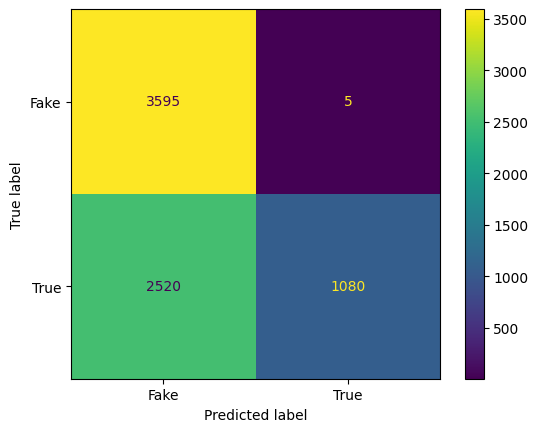

In [57]:
y_test_pred = lr_classifier.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
lr_classifier_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)
cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()



##### Multilayer perceptron (MLP)

              precision    recall  f1-score   support

           0       0.83      0.50      0.62      3600
           1       0.64      0.89      0.75      3600

    accuracy                           0.70      7200
   macro avg       0.73      0.70      0.69      7200
weighted avg       0.73      0.70      0.69      7200



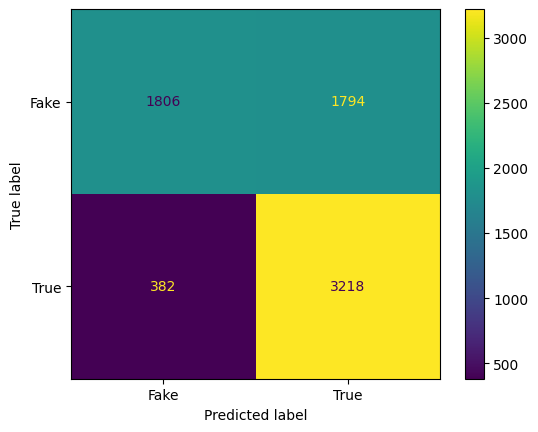

In [58]:
y_test_pred = mlp.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlp_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


##### Multilayer perceptron (MLP) Com GridSearchCV

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3600
           1       0.99      0.34      0.50      3600

    accuracy                           0.67      7200
   macro avg       0.79      0.67      0.63      7200
weighted avg       0.79      0.67      0.63      7200



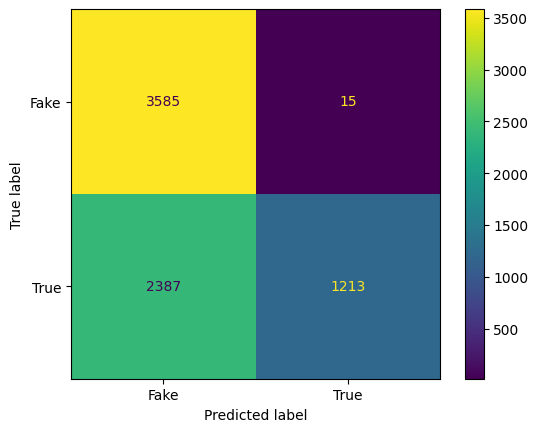

In [59]:

y_test_pred = mlpG.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlpG_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

    

#### Decision Tree

              precision    recall  f1-score   support

           0       0.59      0.92      0.72      3600
           1       0.81      0.36      0.50      3600

    accuracy                           0.64      7200
   macro avg       0.70      0.64      0.61      7200
weighted avg       0.70      0.64      0.61      7200



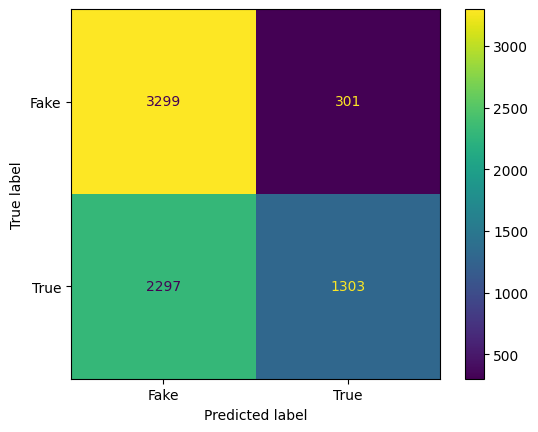

In [60]:
y_test_pred = decisionTree.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
decisionTree_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### RNN

In [61]:

y_test_pred = rnn.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
rnn_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


171/225 [=====================>........] - ETA: 1s

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/embedding/embedding_lookup' defined at (most recent call last):
    File "C:\Users\gyova\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\gyova\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\gyova\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\gyova\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\gyova\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gyova\AppData\Local\Temp\ipykernel_28712\168656189.py", line 1, in <module>
      y_test_pred = rnn.predict(test_padded_seqeunces)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential/embedding/embedding_lookup'
indices[15,141] = 66637 is not in [0, 66594)
	 [[{{node sequential/embedding/embedding_lookup}}]] [Op:__inference_predict_function_25920]

#### LSTM(BI)

36/36 [==============================] - 2s 43ms/step
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       607
           1       0.77      0.92      0.84       545

    accuracy                           0.84      1152
   macro avg       0.85      0.84      0.84      1152
weighted avg       0.85      0.84      0.84      1152



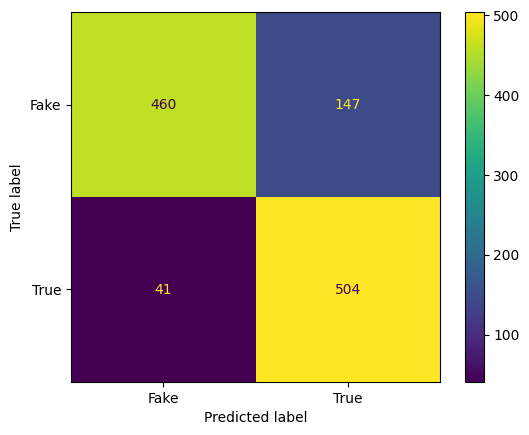

In [ ]:

y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
lstm_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


### Comparando Modelos Diferentes

In [62]:
model = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'MLPClassifier',
        'MLPClassifier with grid',
        'RNN',
        'RNN LSTM(BI)'
    ],
    'Model Accuracy Score': [
        lr_classifier_acc, decisionTree_acc,
        mlp_acc, mlpG_acc,rnn_acc,lstm_acc
    ]
})

In [63]:
model = model.sort_values('Model Accuracy Score',ascending=False)
model

,Model,Model Accuracy Score
5,RNN LSTM(BI),83.68
4,RNN,77.69
2,MLPClassifier,69.78
3,MLPClassifier with grid,66.64
0,Logistic Regression,64.93
1,Decision Tree,63.92
